In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
data = pd.read_csv("/content/gdrive/My Drive/je/data/201901-202003.csv")

* REG_YYMM : 년월
* CARD_SIDO_NM : 카드이용지역_시도(가맹점 주소 기준)
* CARD_CCG_NM : 카드이용지역_시군구 (가맹점 주소 기준)
* STD_CLSS_NM : 업종명
* HOM_SIDO_NM : 거주지역_시도 (고객 집주소 기준)
* HOM_CCG_NM : 거주지역_시군구 (고객 집주소 기준)
* AGE : 연령대
* SEX_CTGO_CD : 성별
* FLC : 가구생애주기 (1: 1인가구, 2: 영유아자녀가구, 3: 중고생자녀가구, 4: 성인자녀가구, 5: 노년가구)
* CSTMR_CNT : 이용고객수(명)
* AMT : 이용금액(원)
* CNT : 이용건수(건)

In [4]:
data.head()

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT
0,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,20s,1,1,4,311200,4
1,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,1,2,7,1374500,8
2,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,2,2,6,818700,6
3,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,3,4,1717000,5
4,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,4,3,1047300,3


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24697792 entries, 0 to 24697791
Data columns (total 12 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   REG_YYMM      int64 
 1   CARD_SIDO_NM  object
 2   CARD_CCG_NM   object
 3   STD_CLSS_NM   object
 4   HOM_SIDO_NM   object
 5   HOM_CCG_NM    object
 6   AGE           object
 7   SEX_CTGO_CD   int64 
 8   FLC           int64 
 9   CSTMR_CNT     int64 
 10  AMT           int64 
 11  CNT           int64 
dtypes: int64(6), object(6)
memory usage: 2.2+ GB


In [7]:
print(data['AMT'].describe())

count    2.469779e+07
mean     2.441353e+06
std      1.726096e+07
min      2.000000e+01
25%      9.020000e+04
50%      2.526800e+05
75%      8.433372e+05
max      2.349524e+09
Name: AMT, dtype: float64


In [8]:
# plt.figure(figsize=(15,10))
# g = sns.heatmap(a.corr(),annot=True,fmt=".2f",cmap='coolwarm')

def grap_year(data):
    data = str(data)
    return int(data[:4])

def grap_month(data):
    data = str(data)
    return int(data[4:])

In [9]:
data = data.fillna('')
data['year'] = data['REG_YYMM'].apply(lambda x: grap_year(x))
data['month'] = data['REG_YYMM'].apply(lambda x: grap_month(x))
data = data.drop(['REG_YYMM'], axis=1)

In [10]:
df = data.copy()
df = df.drop(['CARD_CCG_NM', 'HOM_CCG_NM'], axis=1)

columns = ['CARD_SIDO_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'year', 'month']
df = df.groupby(columns).sum().reset_index(drop=False)

In [14]:
dtypes = df.dtypes
encoders = {}
for column in df.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(df[column])
        encoders[column] = encoder
        
df_num = df.copy()        
for column in encoders.keys():
    encoder = encoders[column]
    df_num[column] = encoder.transform(df[column])

In [15]:
train_num = df_num.sample(frac=1, random_state=0)
x = train_num.drop(['CSTMR_CNT', 'AMT', 'CNT'], axis=1)
y = np.log1p(train_num['AMT'])

In [16]:
k = int(len(x)*0.9)

In [17]:
x_train = x[:k]
y_train = y[:k]
x_val = x[k:]
y_val = y[k:]

In [18]:
import lightgbm as lgb

In [19]:
train_ds = lgb.Dataset(x_train, label=y_train)
val_ds = lgb.Dataset(x_val, label=y_val)

In [20]:
params = {
            'learning_rate' : 0.05,
            'boosting_type': 'gbdt',
            'objective': 'tweedie',
            'tweedie_variance_power': 1.1,
            'metric': 'rmse',
            'sub_row' : 0.75,
            'lambda_l2' : 0.1
        }

In [21]:
model = lgb.train(params,
                  train_ds,
                  1000,
                  val_ds,
                  verbose_eval = 100,
                  early_stopping_rounds = 100
                 )

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.98152
[200]	valid_0's rmse: 1.81073
[300]	valid_0's rmse: 1.68877
[400]	valid_0's rmse: 1.6029
[500]	valid_0's rmse: 1.51398
[600]	valid_0's rmse: 1.44908
[700]	valid_0's rmse: 1.39724
[800]	valid_0's rmse: 1.35602
[900]	valid_0's rmse: 1.31433
[1000]	valid_0's rmse: 1.27941
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 1.27941


In [22]:
CARD_SIDO_NMs = df_num['CARD_SIDO_NM'].unique()
STD_CLSS_NMs  = df_num['STD_CLSS_NM'].unique()
HOM_SIDO_NMs  = df_num['HOM_SIDO_NM'].unique()
AGEs          = df_num['AGE'].unique()
SEX_CTGO_CDs  = df_num['SEX_CTGO_CD'].unique()
FLCs          = df_num['FLC'].unique()
years         = [2020]
months        = [4, 7]

temp = []
for CARD_SIDO_NM in CARD_SIDO_NMs:
    for STD_CLSS_NM in STD_CLSS_NMs:
        for HOM_SIDO_NM in HOM_SIDO_NMs:
            for AGE in AGEs:
                for SEX_CTGO_CD in SEX_CTGO_CDs:
                    for FLC in FLCs:
                        for year in years:
                            for month in months:
                                temp.append([CARD_SIDO_NM, STD_CLSS_NM, HOM_SIDO_NM, AGE, SEX_CTGO_CD, FLC, year, month])
temp = np.array(temp)
temp = pd.DataFrame(data=temp, columns=x.columns)

In [23]:
pred = model.predict(temp)
pred = np.expm1(pred)
temp['AMT'] = np.round(pred, 0)
temp['REG_YYMM'] = temp['year']*100 + temp['month']
temp = temp[['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']]
temp = temp.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM']).sum().reset_index(drop=False)

In [24]:
temp['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp['CARD_SIDO_NM'])
temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp['STD_CLSS_NM'])

In [25]:
submission = pd.read_csv('/content/gdrive/My Drive/je/data/submission.csv', index_col=0)
submission = submission.drop(['AMT'], axis=1)
submission = submission.merge(temp, left_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], right_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], how='left')
submission.index.name = 'id'
submission.to_csv('submission.csv', encoding='utf-8-sig')
submission.head()

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
id,,,,
0,202004,강원,건강보조식품 소매업,2.353337e+08
1,202004,강원,골프장 운영업,1.601208e+09
2,202004,강원,과실 및 채소 소매업,6.451061e+08
3,202004,강원,관광 민예품 및 선물용품 소매업,6.329203e+07
4,202004,강원,그외 기타 분류안된 오락관련 서비스업,2.724102e+07


In [ ]:
data = data.fillna('')
data = data[['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']]
data = data.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM']).sum().reset_index(drop=False)

In [ ]:
submission = pd.read_csv('/content/gdrive/My Drive/je/data/submission.csv', index_col=0)

In [ ]:
import numpy as np

In [ ]:
submission

,CARD_SIDO_NM,STD_CLSS_NM
id,,
0,강원,건강보조식품 소매업
1,강원,골프장 운영업
2,강원,과실 및 채소 소매업
3,강원,관광 민예품 및 선물용품 소매업
4,강원,그외 기타 분류안된 오락관련 서비스업
...,...,...
692,충북,피자 햄버거 샌드위치 및 유사 음식점업
693,충북,한식 음식점업
694,충북,호텔업


In [ ]:
submission = submission.loc[submission['REG_YYMM']==202004]

KeyError: ignored

In [ ]:
submission = submission[['CARD_SIDO_NM', 'STD_CLSS_NM']]
REG_YYMMs = np.sort(data['REG_YYMM'].unique())

In [ ]:
submission

,CARD_SIDO_NM,STD_CLSS_NM
id,,
0,강원,건강보조식품 소매업
1,강원,골프장 운영업
2,강원,과실 및 채소 소매업
3,강원,관광 민예품 및 선물용품 소매업
4,강원,그외 기타 분류안된 오락관련 서비스업
...,...,...
692,충북,피자 햄버거 샌드위치 및 유사 음식점업
693,충북,한식 음식점업
694,충북,호텔업


In [ ]:
AMTs = []
for REG_YYMM in REG_YYMMs:
    df = data.loc[data['REG_YYMM']==REG_YYMM]
    df = df[['CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']]    
    tmp = submission.merge(df, left_on=['CARD_SIDO_NM', 'STD_CLSS_NM'], right_on=['CARD_SIDO_NM', 'STD_CLSS_NM'], how='left')
    tmp = tmp.fillna(0)
    AMT = list(tmp['AMT'])
    AMTs.append(AMT) 

In [ ]:
AMTs = np.array(AMTs)

In [ ]:
def plot_graph(dt, AMTs):
    for i in range(dt, len(AMTs)):
        tmp1 = np.log1p(AMTs[i-dt])
        tmp2 = np.log1p(AMTs[i])
        corr = np.corrcoef(tmp1, tmp2)[0][1]
        plt.title('Correlation: %.4f'%(corr))
        plt.scatter(tmp1, tmp2, color='k', alpha=0.1)
        plt.xlabel('Log AMT, %s'%(REG_YYMMs[i-dt]))
        plt.ylabel('Log AMT, %s'%(REG_YYMMs[i]))
        plt.xlim(tmp1.min(), tmp1.max())
        plt.ylim(tmp1.min(), tmp1.max())
        plt.show()

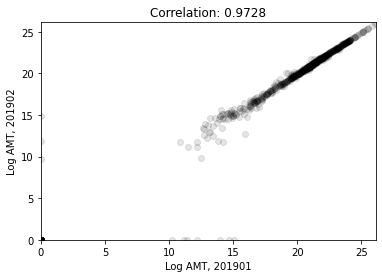

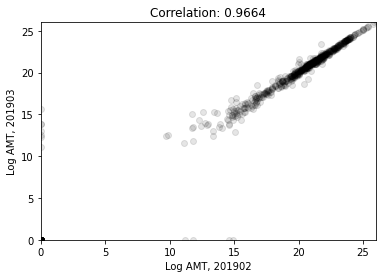

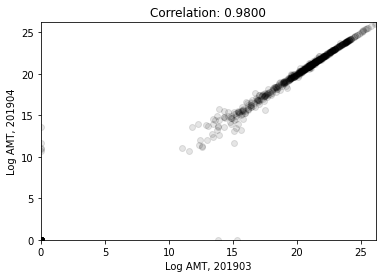

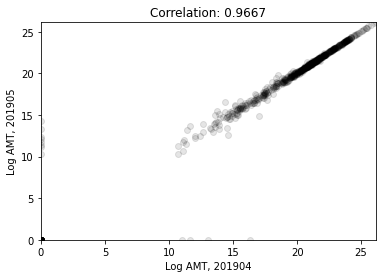

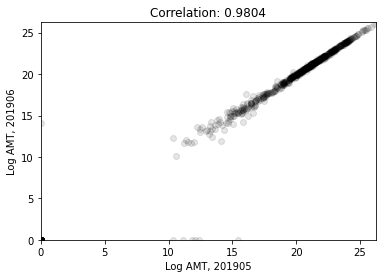

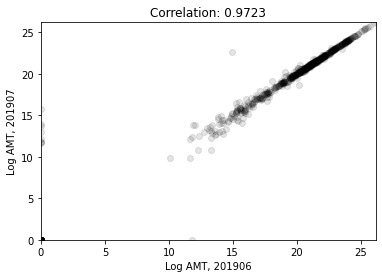

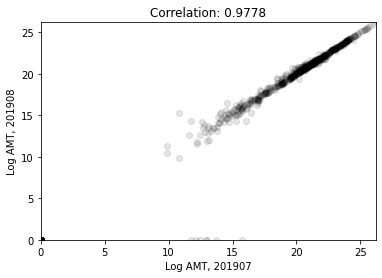

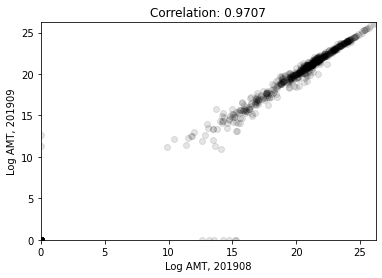

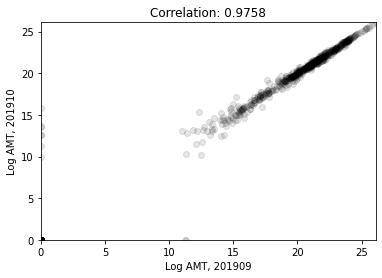

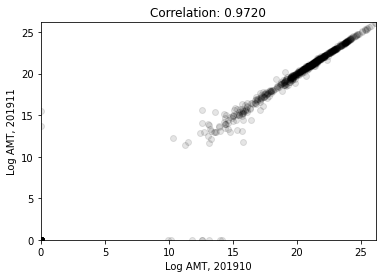

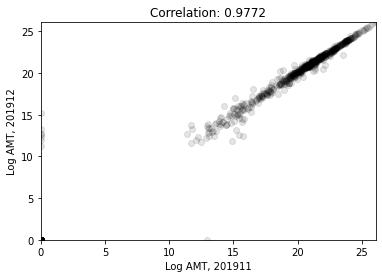

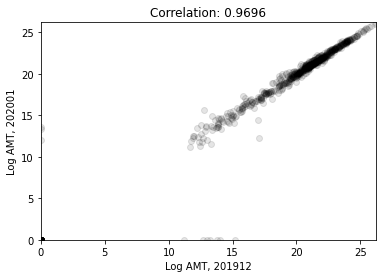

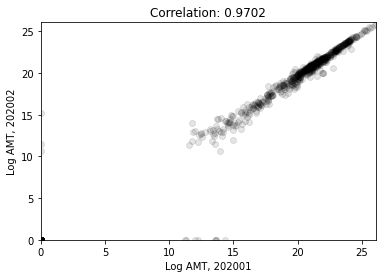

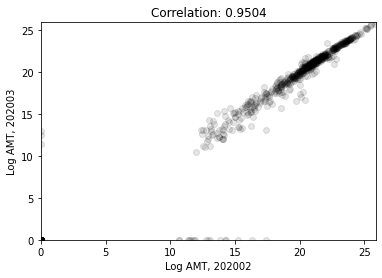

In [ ]:
plot_graph(1, AMTs)

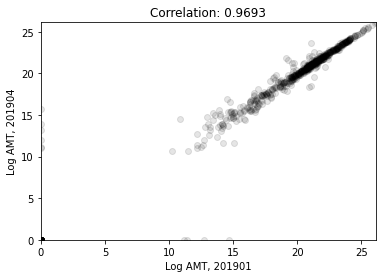

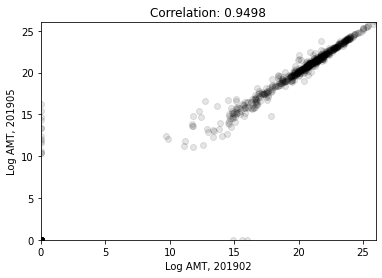

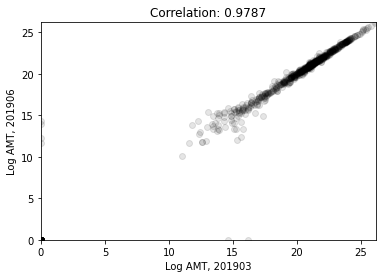

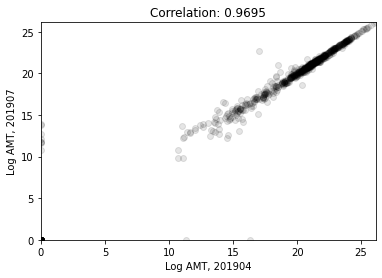

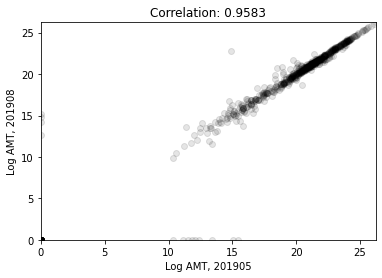

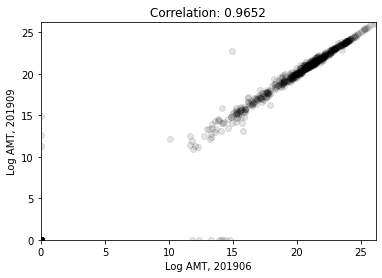

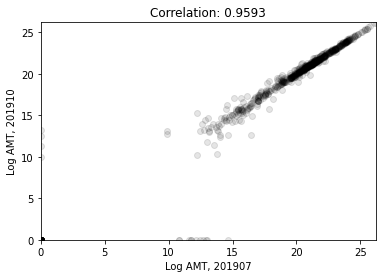

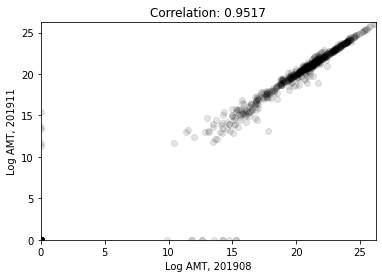

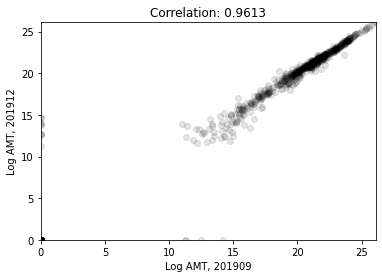

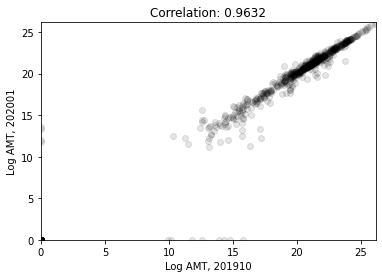

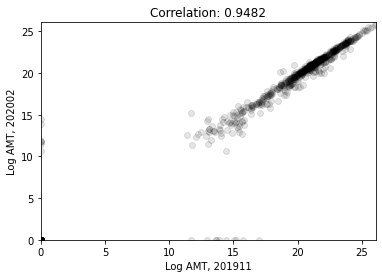

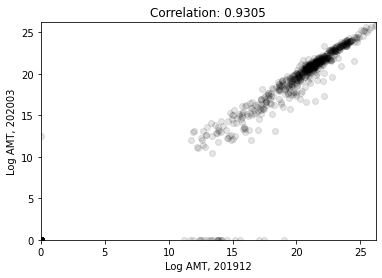

In [ ]:
plot_graph(3, AMTs)

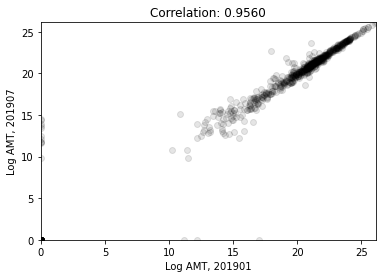

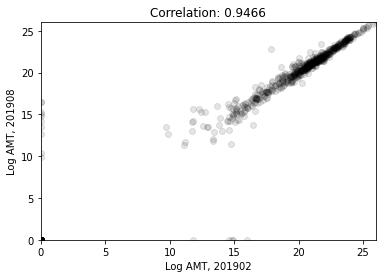

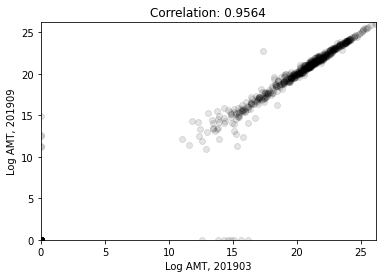

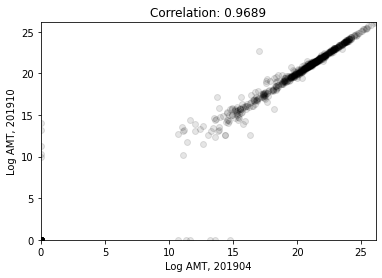

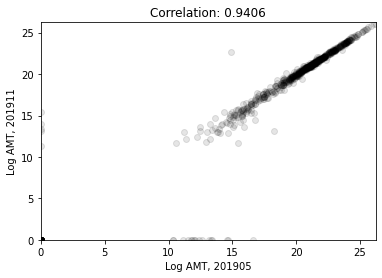

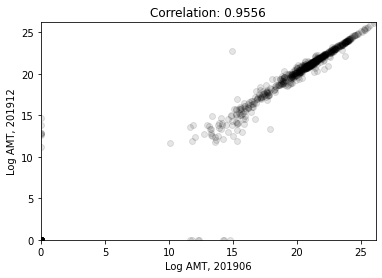

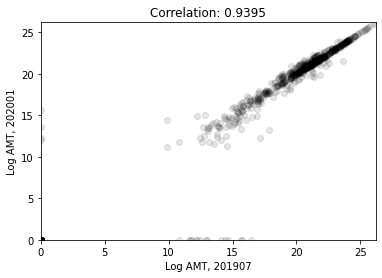

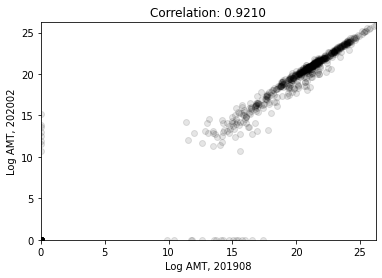

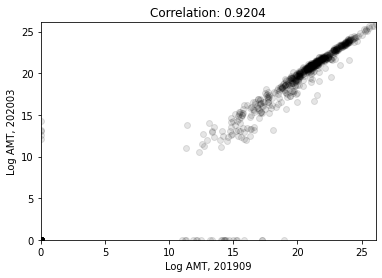

In [ ]:
plot_graph(6, AMTs)